In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import utils.mea_analysis as mea
from sklearn.decomposition import PCA
import seaborn as sns
import re
import os

## Todo:

- [ ] look at attractive region with only good channels in pca plots

 - [x] implement functional channel removal on plotting and pca
 
    - [x] annotate plot_principal_components 
 
    - [x] work on annotating plot_pca_projection
 
    - [x] plot with channels removed
 
 - [ ] add different colours for each channel for voltage plot

    - [x] annotate plot_signal/plot_voltages
 
    - [x] add colours corresponding to each channel
    
    - [x] isolate individual channels
 
    - [ ] investigate removing specific channels that don't show characteristic behaviour
    
  - [ ] pca plot with only good channels in attractive region

- [ ] continue investigating cluster analysis

In [2]:
vdf = pd.read_csv("example_data/MEA002_postS_50V_V.csv",skiprows=22, sep="\t") #import 14-dimensional voltage data
smudf = pd.read_csv("example_data/MEA002_postS_50V_SMU.csv",skiprows=21, sep="\t") #import current/conductance data
filepath = "example_data/MEA002_postS_50V_SMU.csv"

faulty_channels = [] #removing unwanted voltage channels from PCA process
starttime = 0 #start time of time-scale of interest in s
endtime = 16 #end time of time-scale of in in s

In [3]:
vdf = vdf.drop(vdf.index[46000:])
smudf = smudf.drop(smudf.index[230:])

In [4]:
vcols = []
smucols = []

for header in list(vdf):
    header = header.replace("Voltage_", "v")
    header = header.replace("Untitled", "current")
    header = header.replace("X_Value", "time")
    vcols.append(header)
    
for header in list(smudf):
    header = header.replace("Untitled", "current")
    header = header.replace("X_Value", "time")
    smucols.append(header)

vdf.columns = vcols
smudf.columns = smucols

vdf["trel"] = vdf.time - vdf.time.iloc[0]
smudf["trel"] = smudf.time - smudf.time.iloc[0]

vdf.trel = pd.to_numeric(vdf.trel)
smudf.trel = pd.to_numeric(smudf.trel)*10

vdf = vdf.drop(['Comment'], axis=1)
smudf = smudf.drop(['Comment'], axis=1)

In [5]:
print(vdf.trel)

0         0.000
1         0.001
2         0.002
3         0.003
4         0.004
          ...  
22995    22.995
22996    22.996
22997    22.997
22998    22.998
22999    22.999
Name: trel, Length: 23000, dtype: float64


In [6]:
print(smudf.trel)

0       0.0
1       0.1
2       0.2
3       0.3
4       0.4
       ... 
225    22.5
226    22.6
227    22.7
228    22.8
229    22.9
Name: trel, Length: 230, dtype: float64


In [7]:
mea.open_data(filepath,smudf,vdf)

(     time   current  trel  voltage  conductance
 0    0.00  0.000387   0.0       50     0.099871
 1    0.01  0.000384   0.1       50     0.099097
 2    0.02  0.000348   0.2       50     0.089806
 3    0.03  0.000313   0.3       50     0.080774
 4    0.04  0.000298   0.4       50     0.076903
 ..    ...       ...   ...      ...          ...
 225  2.25  0.000362  22.5       50     0.093419
 226  2.26  0.000382  22.6       50     0.098581
 227  2.27  0.000329  22.7       50     0.084903
 228  2.28  0.000317  22.8       50     0.081806
 229  2.29  0.000244  22.9       50     0.062968
 
 [230 rows x 5 columns],
          time        v0         v1         v2        v3         v4         v5  \
 0       0.000  3.375491  -0.252188   0.240782  0.569880  -0.188390  -8.078901   
 1       0.001  3.363361  -0.251002   0.227517  0.556639  -0.187310  -8.076416   
 2       0.002  3.350614  -0.249758   0.213246  0.542328  -0.186162  -8.073895   
 3       0.003  3.338486  -0.248566   0.199379  0.528340 

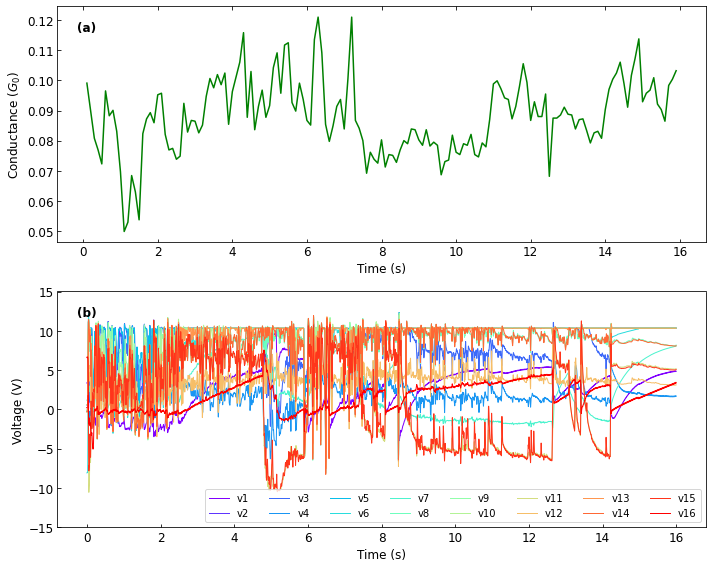

In [8]:
mea.plot_signal(vdf,smudf,faulty_channels,tr=(starttime,endtime),show=True,grouped=False)
imgname = os.path.basename(filepath)[:-4]
plt.savefig(f"plots/{imgname}_{starttime:0.0f}-{endtime:0.0f}s_conductance_and_voltages.png") #_without{faulty_channels}

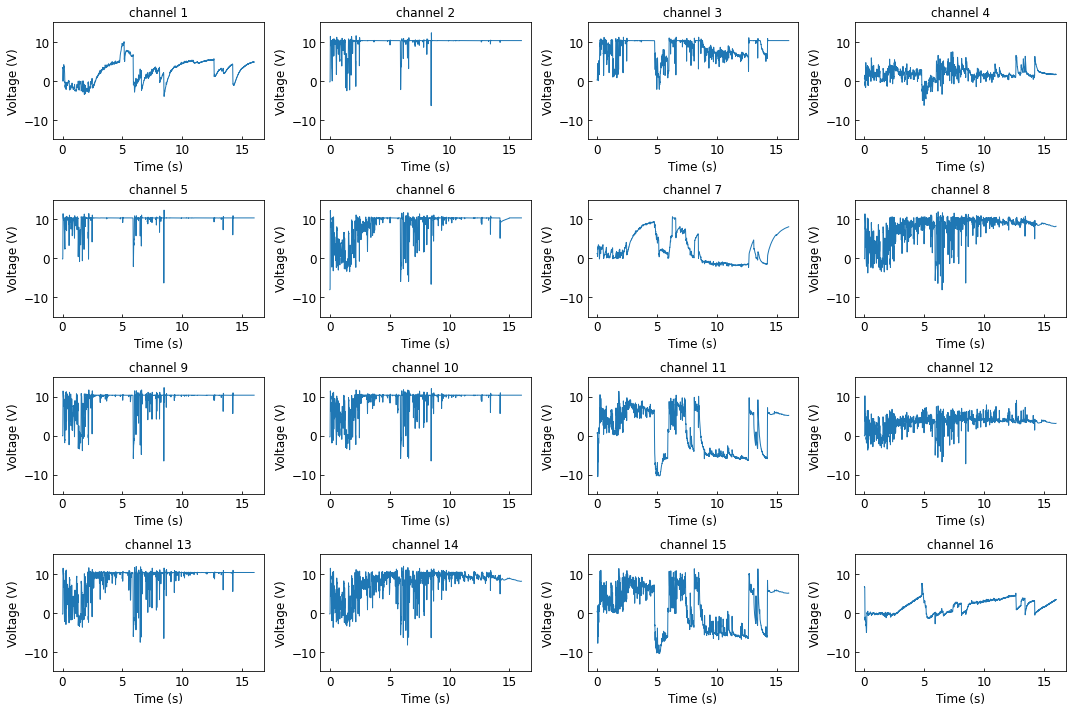

In [9]:
mea.plot_stacked_voltages(vdf,faulty_channels,tr=(starttime,endtime),show=True)
plt.savefig(f"plots/{imgname}_{starttime:0.0f}-{endtime:0.0f}s_individual_voltages.png") #_without{faulty_channels}

In [10]:
dg, iei =mea.analyze_events(smudf,gthresh=0.01)

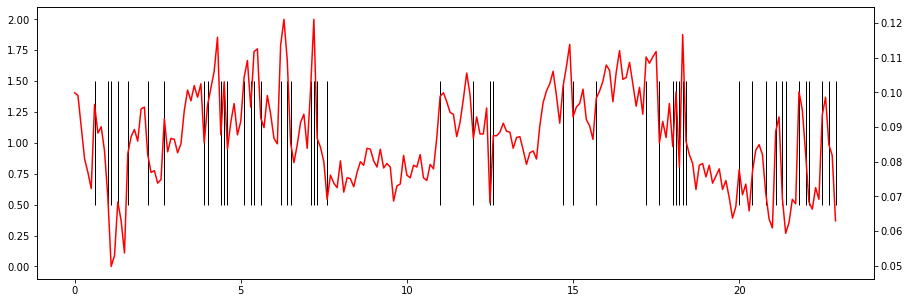

In [11]:
fig, ax = plt.subplots(nrows=1,figsize=(15,5))
ax.eventplot(dg[:,1],linewidth=1,color='k')
ax2=ax.twinx()
ax2.plot(smudf.trel,smudf.conductance,'r')

Text(0.5, 1.0, 'loglog interevent interval length histogram')

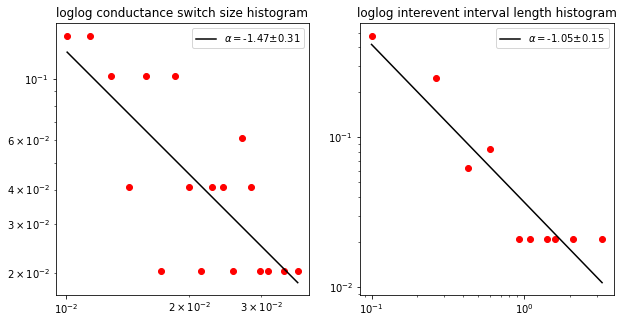

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
mea.plot_loglog(dg[:,0],axes[0])
mea.plot_loglog(iei,axes[1])
axes[0].set_title("loglog conductance switch size histogram")
axes[1].set_title("loglog interevent interval length histogram")

In [13]:
resd_all = vdf.iloc[:,3:-1].to_numpy()

In [14]:
print(resd_all.shape)
print(resd_all.ndim)
print(resd_all.size)

(23000, 14)
2
322000


In [15]:
for m in range(14):
    print(resd_all[2,m])

0.213246
0.5423279999999999
-0.186162
-8.073895
1.1680110000000001
-0.126891
-0.073719
-0.346453
0.605088
-0.083467
-0.317565
-0.289481
0.227255
6.62056


In [16]:
resd = np.delete(resd_all, faulty_channels, axis=1)

In [17]:
print(resd.shape)
print(resd.ndim)
print(resd.size)

(23000, 14)
2
322000


In [18]:
msstarttime = int(starttime*1000)
msendtime = int(endtime*1000)
print(msstarttime)
print(msendtime)

6000
7000


In [19]:
resd = resd[msstarttime:msendtime,:]

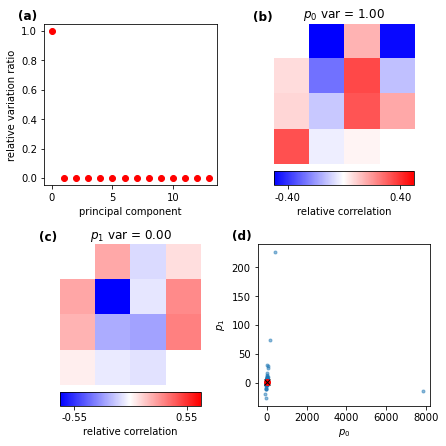

In [20]:
mea.plot_principal_components(resd, faulty_channels, show = True, ends = True)
imgname = os.path.basename(filepath)[:-4]
plt.savefig(f"plots/{imgname}_{starttime:0.0f}-{endtime:0.0f}s_PCA.png") #_without{faulty_channels}

### Manual PCA exploration

For neds ongoing python education: making a class and doing some stuff with methods and attributes

In [ ]:
class dog:
    def __init__(self, color): # this is a special method because of the __ or dunder method
        """ gets run whenever you make a new dog"""
        self.color = color #this sets color as the value for the attribute
        print(f"making a {self.color} dog")
        
    def bark(self): # this is a method, methods are functions that are attached to objects
        print(f"woof {self.color}")

In [ ]:
d = dog('black')
e = dog('white')
d.bark()
d.color='green'
d.bark()

In [ ]:
# This step is VITAL for reasonable PCA. without some form of normalization pca is pretty odd.
# resd is the original data
# resd is an np array where each column is a dimension (voltage channel)
# and each row is a measurement of all dimensions (voltage at a time)
# normalise resd, to make PCA play nice
# can normalise in a number of ways, eg normalise by the whole dataset mean etc
resd = np.array([(point - point.mean()) / point.mean() for point in resd])

In [ ]:


# from sklearn.decomposition import PCA
# instantiating a PCA oject
pca = PCA()


# perform the fit method of the pca object using our normalised data
pca.fit(resd)
# fit just refers to finding the pricipal components and score that "fit" your specific data (resd)


In [ ]:
pc = pca.components_ # attribute of the pca object after we have done fit

In [ ]:
pc.shape # 14 by 14 (or n by n, where n is the total number of channels used) vector, with rows = components, and columns = number of dimensions of input data

#### principal component channel removal

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.3, 6.3))

In [ ]:
# plots the relative variance that is due to each of the pc vectors
axes.flat[0].plot(pca.explained_variance_ratio_, "ro")
axes.flat[0].set_ylabel("relative variation ratio")
axes.flat[0].set_xlabel("principal component")

In [ ]:
display_pc = np.insert(pc, faulty_channels, np.nan, axis=1)  # adds in empty values to allow 4x4 display of vectors

In [ ]:
display_pc.shape # gives the size of the np array display_pc as a tuple

In [ ]:
vector_0 = np.insert(display_pc[0], [0, 14], np.nan).reshape((4, 4)) #places 1st principle component basis vector into a 4x4 array with nan at indices 0 and 14 (source and drain)
print(vector_0)
vector_1 = np.insert(display_pc[1], [0, 14], np.nan).reshape((4, 4)) #places 2nd principle component vector into a 4x4 array with nan at indices 0 and 14 (source and drain)
print(vector_1)
vrange_0 = np.nanmax(abs(vector_0))
print(vrange_0)
vrange_1 = np.nanmax(abs(vector_1))
print(vrange_1)

In [ ]:
im_0 = axes.flat[1].imshow(vector_0, cmap="bwr", vmax=vrange_0, vmin=-vrange_0) #displays each component vector using a blue/white/red colour map with a range defined by vrange
im_1 = axes.flat[2].imshow(vector_1, cmap="bwr", vmax=vrange_1, vmin=-vrange_1) #"1" and "2" refer to the index of the image within the array of subplots, defined early when
                                                                                #"axes" was created  

In [ ]:
axes.flat[1].axis("off") # turns off axes and axes values in the component vector displays
axes.flat[1].set_title(
    "$p_0 var$ = {:0.2f}".format(pca.explained_variance_ratio_[0]) #adds the percentage of variance this component vector accounts for as the title, 2dp
)

In [ ]:
axes.flat[2].axis("off")
axes.flat[2].set_title(
    "$p_1 var$ = {:0.2f}".format(pca.explained_variance_ratio_[1])
)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable #package that allows colorbar to placed in a specific location

divider_0 = make_axes_locatable(axes.flat[0])                #returns instance of AxesLocator class, providing append_axes method, used to create a new axes for a component 
                                                             #vector grid
cax_0 = divider_0.append_axes("bottom", size="10%", pad=0.1) #cax is the axes into which the colorbar is drawn - cax axes is created below old axes, with width 0.1*axes and a
                                                             #distance of 0.1in between axes and cax
cb_0 = plt.colorbar(                                         
    im_0, cax=cax_0, orientation="horizontal", label="V", format="%.2f" #adds colorbar "cb" to plot, where im is the image descibed by the colorbar, cax is the new axes
)                                                                       #orientation=colorbar orientation, label=label on colorbar's long axis, format=no. decimal points on scale

divider_1 = make_axes_locatable(axes.flat[1])
cax_1 = divider_1.append_axes("bottom", size="10%", pad=0.1)
cb_1 = plt.colorbar(
    im_1, cax=cax_1, orientation="horizontal", label="V", format="%.2f"
)

In [ ]:
cmin_0 = -vrange_0        # colorbar min value
cmax_0 = vrange_0         # colorbar max value
span_0 = cmax_0 - cmin_0  # colorbar range
        
cb_0.set_ticks([cmin_0 + (0.1 * span_0), cmax_0 - (0.1 * span_0)]) #Set the locations of the tick marks from sequence
cb_0.set_ticklabels(
    ["{:.2f}".format(cmin_0 + (0.1 * span_0)), "{:.2f}".format(cmax_0 - (0.1 * span_0))] #Adds the voltage correlations corresponding to the locations of the ticks on the colorbar
)
cb_0.set_label("relative correlation") #adds a label to the colorbar

cmin_1 = -vrange_1      
cmax_1 = vrange_1        
span_1 = cmax_1 - cmin_1
        
cb_1.set_ticks([cmin_1 + (0.1 * span_1), cmax_1 - (0.1 * span_1)])
cb_1.set_ticklabels(
    ["{:.2f}".format(cmin_1 + (0.1 * span_1)), "{:.2f}".format(cmax_1 - (0.1 * span_1))]
)
cb_1.set_label("relative correlation")

In [ ]:
# projection of the measurements in resd on to the principal components 

ax.plot(
    resd.dot(pc[0]), #x-axis is projection onto 1st principal component p_0
    resd.dot(pc[1]), #y-axis is projection onto 2nd principal component p_1
    ls="", #linestyle
    marker=".", #marker style
    alpha=0.5, #sets alpha value (0.0 for fully transparent, 1.0 for fully opaque)
)

In [ ]:
#displays marker corresponding to the first data point in resd 

ax.plot(
    resd.dot(pc[0])[0], #x-axis is projection onto 1st principal component p_0 by 1st data point (index 0)
    resd.dot(pc[1])[0], #y-axis is projection onto 2nd principal component p_1 by 1st data point (index 0)
    "ro", #marker formatting - red circle
)

In [ ]:
#displays marker corresponding to the final data point in resd 

ax.plot(
    resd.dot(pc[0])[-1],  #x-axis is projection onto 1st principal component p_0 by last data point (index -1)
    resd.dot(pc[1])[-1],  #y-axis is projection onto 2nd principal component p_1 by last data point (index -1)
    "kx", #marker formatting - black x
)

In [ ]:
axes.flat[3].set_ylabel("$p_1$") #sets y-axis title to p_1

In [ ]:
axes.flat[3].set_xlabel("$p_0$") #sets x-axis title to p_0

In [ ]:
print(axes.shape)

In [ ]:
#adding sublabels for each subplot

sublabels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"] 

for i in range(len(axes.flat)): #iterates over each of the four subplots (axes)
    axes.flat[i].text(
        -0.15,
        1.05,                   #(x,y) coordinates of each sublabel
        sublabels[i],
        horizontalalignment="left",  #alignment of each sublabel
        verticalalignment="center",
        transform=axes.flat[i].transAxes,  #sets (x,y) coordinates to be relative to the axes of the specific subplot being iterated over
        color="k",                  #color, size and style of each sublabel
        size="large",
        weight="bold",
    )

plt.tight_layout() #fits subplots into figure

#### principal component manual exploration

In [ ]:
# first 14-d (n-d) normalised vector
resd[0]

In [ ]:
# first two principal component vectors.
# eg. 0th row, all columns = [0,:] etc.
pc1 = pc[0, :]
pc2 = pc[1, :]

In [ ]:
# projection of the first normalized vector of original vector onto first and second pc. 
# to what extent is this vector represented by each pc
resd[0].dot(pc1), resd[0].dot(pc2)

In [ ]:
# matrix multiplication of the first two pc vectors with the first data vector
resd[0].dot(pc[:2,:].T)

In [ ]:
# doing the matrix mult, with the first two pc, and the whole matrix of (n, 14) resd matrix
# (n, 14).(14,2) -> (n,2)
projection = resd.dot(pc[:2,:].T)

In [ ]:
plt.scatter(projection[:,0], projection[:,1], alpha=0.2)
# plt.xlim((0,200))
# plt.ylim((-10,59))

In [ ]:
sns.kdeplot(projection[:,0], projection[:,1], shade=True)

### isolate channels when plotting signal (plot_signal)

In [ ]:
tr=(0, 10000) #time period of interest
vr=(0, 16) #channels of interest

In [ ]:
sdf = smudf.copy() #ensures the original list smudf is unchanged when sdf is altered

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(6.3, 6.3)) #creates a set of subplots in a single figure

In [ ]:
mea.plot_conductance(sdf, axes.flat[0], tr) #function creates conductance subplot

In [ ]:
vdf = vdf[(vdf.trel > tr[0]) & (vdf.trel < tr[1])] #removes all elements outside the time period of interest

In [ ]:
print(vdf.head())
print(vdf.tail())

In [ ]:
ax = axes.flat[1] #"1" refers to the index of the subplot within the array of subplots, defined when "axes" was created

In [ ]:
num_colors = vr[1]
cmap = cm.Set1(np.linspace(0,1,num_colors-1))
ax.set_prop_cycle('color', cmap.tolist())

In [ ]:
for i in range(*vr): #iterates over channels of interest, * indicates an arbitary number of arguments
    if i in faulty_channels:
        pass
else:
    ax.plot(
    vdf.trel,                    #x-coordinates of plotted line (relative time)
    vdf[list(vdf)[i + 1]],       #y-coordinates of plotted line (relative time)
    alpha=1,                     #fully opaque
    linewidth=0.5,
)

In [ ]:
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Voltage (V)", fontsize=12)
ax.tick_params(direction="in", which="both") #causes ticks to point into the box, on both x and y axes

In [ ]:
for label in (
    axes.flat[1].get_xticklabels()
    + axes.flat[1].get_yticklabels()
    + axes.flat[0].get_xticklabels()
    + axes.flat[0].get_yticklabels()
):
    label.set_fontsize(12) #sets fontsize of all tick labels to 12

In [ ]:
sublabels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"] 

for i in range(len(axes)): #describes position of each subplot within the figure
    axes[i].text(
    0.03, #x-position of subplot
    0.91, #y-position of subplot
    sublabels[i],                   
    horizontalalignment="left",
    verticalalignment="center", #alignment of sublabels 
    transform=axes[i].transAxes, #sets (x,y) coordinates to be relative to the axes of the specific subplot being iterated over
    color="k", #color, size and style of each sublabel
    size="large",
    weight="bold",
)

In [ ]:
plt.tight_layout()